In [1]:
# Import public packages.
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import ndimage as ndi 
from importlib import reload
import pickle
import czifile
from skimage.filters.thresholding import threshold_otsu

# The order of loading matplotlib is important to avoid issues on my machine.
%matplotlib inline
import matplotlib as mpl
#%matplotlib notebook
#%matplotlib notebook

# Import my packages.
import flymovie as fm

# Activate package autoload.
%load_ext autoreload
%autoreload 2


Goals:

1. Apply computed correction parameters to MS2 data
2. Develop a 'from-the-data' correction for MS2 data

### Standard candle based:



In [8]:
# Set channels corresponding to nuclear signal and MS2 spots.
nucchannel = 0
spotchannel = 1
# Set files for output movie object and input files.
mv_filename = '/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/20210518-rpb1gfp-evems2-em2-01-05.pkl'
czi_folder = '/Volumes/Stadler100/2021-04-02/'
czi_files = ['20210402-mNeonZld-hbms2-zsmv-em1-05.czi']

In [119]:
# Read and join czi files into single image stack, recording frames at which movies
# are joined and starting Z positions.
stack, join_frames, starting_positions, z_interval = fm.read_czi_multiple(czi_files, czi_folder)
mv = fm.load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/20210402-mNeonZld-hbms2-zsmv-em1-05.pkl')

In [484]:
############################################################################
def spot_data_add_depth(spot_data, surface_before, surface_after,
    join_frames, start_positions, z_interval=0.5):
    """Add a column to spot_data with the absolute embryo depth of every
    detected spot.

    Args:
        spot_data: dict of ndarrays
            Column 0 must be frame number (time), column 2 must be Z slice
        surface_before: float
            Position of embryo surface measured before taking stack, in 
            microns
        surface_after: float
            Position of embryo surface measured after taking stack, in 
            microns
        join_frames: iterable of ints
            Positions of frames where movies are joined
        start_positions: iterable of numeric
            Positions of the start (lowest Z slice) of z stack for each
            constituent stack
        z_interval: float
            Interval between Z slices, in microns
        
    Returns:
        spot_data_wdepth: dict of ndarrays
            Input spot_data object, with column added containing calibrated
            absolute embryo depth
    """
    def get_nframes(spot_data):
        """Get max frame number from spot_data object."""
        last_frame_all = 0
        for spot_id in spot_data:
            last_frame_spot = spot_data[spot_id][-1, idx_t]
            if last_frame_spot > last_frame_all:
                last_frame_all = last_frame_spot
        return last_frame_all + 1

    def make_surface_vector(before, after, nframes):
        """Make vector of inferred embryo surface positions for each frame,
        assuming drift occurs at a constant rate."""
        increment = (after - before) / nframes
        surface_position = np.arange(before, after, increment)
        return surface_position
    
    def make_true_start_vector(surface_positions, join_frames, start_positions):
        """Make vector of the true start position of the Z stack for every frame,
        calculated as the difference between the inferred embryo surface position
        and the z-stack start position stored in metadata."""
        nframes = len(surface_positions)
        # Add last frame to join_frames list.
        join_frames = join_frames + [nframes]
        # First, make a vector (of length = nframes) with the uncorrected
        # z-stack start position for each frame. 
        # Start at 0. Join frames starts with the first junction, so for each 
        # junction make the part of the vector between this junction and the 
        # previous junction.
        curr_segment_start = 0
        start_positions_uncorrected = np.array([])
        for n in range(0, len(join_frames)):
            length = join_frames[n] - curr_segment_start
            start_pos = float(start_positions[n])
            start_positions_uncorrected = np.concatenate([start_positions_uncorrected,
                                                    np.repeat(start_pos, length)])
            curr_segment_start = join_frames[n]

        # Get corrected z-stack start positions by subtracting inferred embryo
        # surface positions.
        start_positions_corrected =  start_positions_uncorrected - surface_positions
        return start_positions_corrected
        
    def add_depth_column(spot_data, start_positions, z_interval):
        """Add new column to spot_data with absolute embryo depth."""
        spot_data_wdepth = {}
        for spot_id in spot_data:
            arr = spot_data[spot_id].copy()
            # Add new blank column of 0s.
            arr = np.append(arr, np.zeros((arr.shape[0],1)), axis=1)
            # Fill in data row by row.
            for row in range(0, arr.shape[0]):
                t,z = arr[row, idx_t], arr[row, idx_z]
                slice_depth = start_positions[int(t)] + (z * z_interval)
                arr[row, -1] = slice_depth
            spot_data_wdepth[spot_id] = arr
        return spot_data_wdepth

    # Set indexes for frame (time) and z slice in spot_data, get nframes.
    idx_t = 0
    idx_z = 2
    nframes = get_nframes(spot_data)
    # Get surface positions, then z-stack start positions, then add depth column.
    surface_positions = make_surface_vector(surface_before, surface_after, nframes)
    start_positions = make_true_start_vector(surface_positions, join_frames, start_positions)
    spot_data_wdepth = add_depth_column(spot_data, start_positions, z_interval)           
    return spot_data_wdepth

In [485]:
spot_data_depth2 = spot_data_add_depth(mv.spot_data, surface_before=1527.61, surface_after=1523.40,
    join_frames=[], start_positions=[1533.66], z_interval=0.50)

hullelujah


In [487]:
reload(fm)
spot_data_depth2 = fm.spot_data_add_depth(mv.spot_data, surface_before=1527.61, surface_after=1523.40,
    join_frames=[], start_positions=[1533.66], z_interval=0.50)

In [450]:
for spot_id in spot_data_depth:
    assert np.array_equal(spot_data_depth[spot_id], spot_data_depth2[spot_id])

In [157]:
test = spot_data_add_depth(mv.spot_data, mv.stack, surface_before=1525, surface_after=1525.001,
    join_frames=join_frames, start_positions=starting_positions, slice_thickness=0.66)

[1525.     1525.0002 1525.0004 1525.0006 1525.0008]
[9.66   9.6598 9.6596 9.6594 9.6592]


In [158]:
spot_id = 12
row = 3
print(test[spot_id][row,:])
print('')
print(mv.spot_data[spot_id][row,:])

[3.00000000e+00 3.00000000e+01 1.20000000e+01 2.66000000e+02
 4.14000000e+02 6.03556310e+03 1.41315479e+00 5.81865335e+00
 5.18428137e+00 4.92561935e+03 3.36084272e+03 3.65072903e+03
 1.75794000e+01]

[3.00000000e+00 3.00000000e+01 1.20000000e+01 2.66000000e+02
 4.14000000e+02 6.03556310e+03 1.41315479e+00 5.81865335e+00
 5.18428137e+00 4.92561935e+03 3.36084272e+03 3.65072903e+03]


OK so we've got the depth calculation. We can correct by using the fits from 120-mer data, or by just getting the kink out of the data. I'll start with the standard candles.

In [138]:
# Should yield 1 for everything
paramgrids_null = (np.ones((250, 200)), np.zeros((250, 200)), np.zeros((250, 200)))

In [152]:
paramgrids_real = fm.load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/20210613-depth-correction-params.pkl')

In [480]:
from copy import deepcopy

def spot_data_extract_depthbinned_intensities(spot_data, col_depth, col_to_bin, 
        bin_size=0.5, nbins=100):
        """Build vector of intensities binned by depth and their means.
        
        Args:
            spot_data: dict of ndarrays
                spot_data object
            col_depth: int
                Column in spot_data containing embryo depth
            col_to_bin: iterable of ints
                Columns in spot_data to correct
            bin_size: numeric
                Size of bins for depth, in microns
            nbins: int
                Number of bins to make
        
        Returns:
            vals: list of lists
                Each value in parent list is a depth bin, each bin contains
                a list of all values from col_to_bin at in that depth range
        """
        vals = [[]] * nbins
        for spot_id in spot_data:
            arr = spot_data[spot_id]
            for row in range(0, arr.shape[0]):
                # Convert depth to array index in 0.5 µm increments.
                depth = int(arr[row, col_depth] / bin_size)
                vals[depth] = vals[depth] + [arr[row, col_to_bin]]
        return vals

def spot_data_depth_correct_stdcandle(spot_data, paramgrids, col_to_correct=9, col_depth=12, target_depth=10):
    """Correct spot_data object using parameters derived from standard candles.

    Args:
        spot_data: dict of ndarrays
            Column 0 must be frame number (time), column 2 must be Z slice
        paramgrids: tuple of ndarrays
            Depth by intensity arrays of exponential parameters a, b, c, 
            according to function intensity = a * e^(-b * depth) + c
            Units are 0.1 µm on the depth axis and 100 a.u. on the intensity
            axis. For a spot measures at depth 10 microns of intensity 
            5000, parameters would be drawn from position (100, 50).
        col_depth: int
            Column in spot_data containing embryo depth
        col_to_correct: iterable of ints
            Column in spot_data to correct
        target_depth: numeric
            Reference depth to which all spots will be corrected

    Returns:
        spot_data_corr: dict of ndarrays
            Input spot_data with indicated columns corrected for depth
    
    
    """
    def calc_exponential(depth, a, b, c):
        """Return value of exponential function a * e^(-b * depth) + c."""
        return a * np.exp(-b * depth) + c
    
    paramgrid_a, paramgrid_b, paramgrid_c = paramgrids
    spot_data_corr = deepcopy(spot_data)
    for spot_id in spot_data:
        for row in range(0, spot_data[spot_id].shape[0]):
            depth = spot_data[spot_id][row, col_depth]
            intensity = spot_data[spot_id][row, col_to_correct]
            paramgrid_position_intensity = int(intensity / 100)
            paramgrid_position_depth = int(depth / 0.1)
            a = paramgrid_a[paramgrid_position_depth, paramgrid_position_intensity]
            b = paramgrid_b[paramgrid_position_depth, paramgrid_position_intensity]
            c = paramgrid_c[paramgrid_position_depth, paramgrid_position_intensity]
            intensity_corr = calc_exponential(target_depth, a, b, c)
            spot_data_corr[spot_id][row, col_to_correct] = intensity_corr
    
    # Plot boxplot of intensity vs. depth for uncorrected and corrected data.
    vals = spot_data_extract_depthbinned_intensities(spot_data, col_depth, col_to_correct)
    plt.subplot(211)
    plt.boxplot(vals[10:40])
    plt.ylim(0,15000)
    vals_corr = spot_data_extract_depthbinned_intensities(spot_data_corr, col_depth, col_to_correct)
    plt.subplot(212)
    plt.boxplot(vals_corr[10:40])
    plt.ylim(0,15000)
    
    return spot_data_corr

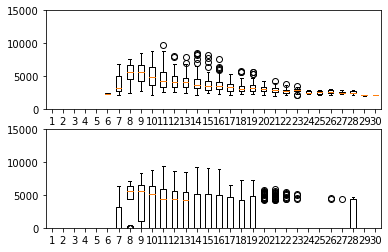

In [481]:
catch2 = spot_data_depth_correct_stdcandle(spot_data_depth, paramgrids_real)

In [170]:
spot_id=2
col = 11

print(test[spot_id][:,12])
print(test[spot_id][:,col])
print(c[spot_id][:,col])

[9.66   9.6598 9.6596 9.6594 9.6592]
[6169.34210526 4823.33333333 4315.62790698 4406.34666667 4011.        ]
[10869.54567683  8290.55757725  6887.47104124  7195.74991135
     0.        ]


This seems to work. I'll need to test it more in some ways, but it seems to behave at least plausibly well.

### Data-based

In [171]:
spot_data_depths = test

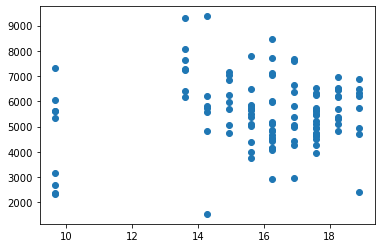

In [179]:
col=9

depths = []
intensities = []

for spot_id in spot_data_depths:
    arr = spot_data_depths[spot_id]
    depths = depths + list(arr[:,12])
    intensities = intensities + list(arr[:,col])

plt.scatter(depths, intensities);

I think if I have data with absolute depth data, I could combine a lot of data and derive some correction calculations.

Unfortunately I don't currently have data for any movies with measured surfaces (it's on the scope and I apparently forgot to pull it). I'm going to work with the movie from em2 from 5/17 in the meantime.

In [198]:
folder = '/Volumes/Stadler100/2021-05-17'
files = ['20210517-Rpb1GFP-eveMS2-zsmv-em2-02.czi',
'20210517-Rpb1GFP-eveMS2-zsmv-em2-03.czi',
'20210517-Rpb1GFP-eveMS2-zsmv-em2-04.czi',
'20210517-Rpb1GFP-eveMS2-zsmv-em2-05.czi',
'20210517-Rpb1GFP-eveMS2-zsmv-em2-06.czi',
'20210517-Rpb1GFP-eveMS2-zsmv-em2-08.czi',
'20210517-Rpb1GFP-eveMS2-zsmv-em2-09.czi'
]
starting_positions, z_interval = fm.read_czi_multiple(files, folder, metadata_only=True)

In [201]:
starting_positions

[-490.41,
 -491.65999999999997,
 -492.71999999999997,
 -494.25999999999993,
 -495.73999999999995,
 -497.7,
 -495.85]

OK, I don't have the measurements, but let's assume the Z stacks start ~5 µm into embryo, and that they're consistent. That would mean the embryo surface starts at ~-495.41 and falls to -500.85. This seems quasi-reasonable to just start working on the code.

In [204]:
mv = fm.load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/20210517-Rpb1GFP-eveMS2-zsmv-em2-02-09.pkl')

In [208]:
z_interval

0.5

In [ ]:
spot_data_dc = spot_data_add_depth(mv.spot_data, mv.stack, surface_before=-495.41, surface_after=-500.85,
    join_frames=frames, start_positions=starting_positions, slice_thickness=0.5)

In [232]:
spot_data_dc = spot_data_add_depth(mv.spot_data, mv.stack, surface_before=-495.41, surface_after=-500.85,
    join_frames=frames, start_positions=starting_positions, slice_thickness=0.5)

16
17
17
17
43
24
11


In [318]:
spot_data_dc = spot_data_add_depth(mv.spot_data, mv.stack, surface_before=-495, surface_after=-505.001,
    join_frames=frames, start_positions=starting_positions, slice_thickness=0.5)

How much does spot depth vary in this dataset?

In [237]:
depth = fm.movie.make_spot_table(spot_data_dc, mv.nucmask, 12)

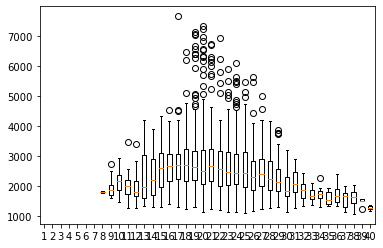

In [319]:
col = 9
vals = [[]] * 40

for spot_id in spot_data_dc:
    arr = spot_data_dc[spot_id]
    for row in range(0, arr.shape[0]):
        d = int(arr[row, 12] / 0.5)
        vals[d] = vals[d] + [arr[row, col]]

plt.boxplot(vals);

OK, I processed a new dataset (5-19-21, em4-1), the only one I have depth measurements for. Unfortunately it was the MCP-PCP experiment, rather than an Rpb1 dataset, but let's see what we see.

In [320]:
mv = fm.load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/20210519-MCPPCP-em4-01.pkl')

In [327]:
spot_data_depth = spot_data_add_depth(mv.spot_data, mv.stack, surface_before=1527.61, surface_after=1523.40,
    join_frames=[], start_positions=[1533.66], slice_thickness=0.50)

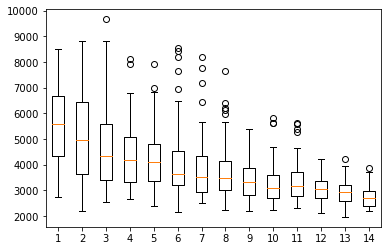

In [344]:
col = 9
vals = [[]] * 40

for spot_id in spot_data_depth:
    arr = spot_data_depth[spot_id]
    for row in range(0, arr.shape[0]):
        d = int(arr[row, 12] / 0.5)
        vals[d] = vals[d] + [arr[row, col]]

plt.boxplot(vals[18:32]);

<ipython-input-350-616c0dd1708a>:3: RuntimeWarning: Mean of empty slice
  med_ = np.nanmean(vals[n])


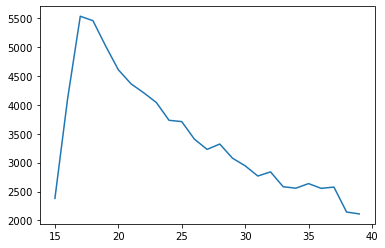

In [350]:
meds = []
for n in range(0, len(vals)):
    med_ = np.nanmean(vals[n])
    meds.append(med_)

plt.plot(meds)

OK I need a function that:

1. Takes in a spot_data (w/ depth), start positions, join frames, etc.
3. Makes vector of depth vs. intensity
4. Fits a function to that curve
5. Corrects input columns
6. Plots relevant things

/Users/michaelstadler/Bioinformatics/Projects/rpb1/bin/flymovie/analyze.py:667: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c
/Users/michaelstadler/Bioinformatics/Projects/rpb1/bin/flymovie/analyze.py:667: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c


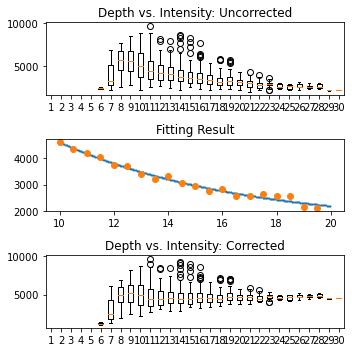

In [490]:
############################################################################
from scipy.optimize import curve_fit
def spot_data_depth_correct_fromdata(spot_data, col_to_correct=9, 
    col_depth=12, target_depth=10):
    """Apply sample depth correction to a column in spot_data by equalizing 
    the mean values of the feature across sample depths.

    For the indicated column, mean values are determined for 0.5 µm bins
    of sample depth. These depth vs. intensity curves are fitted with an 
    exponential function, and this function is used to correct all 
    values in the datasest.
    
    
    """
    def exp_func(x, a, b, c):
        """Return value of exponential function a * e^(-b * x) + c."""
        return a * np.exp(-b * x) + c
    
    def get_intercept(x, y, a, b):
        """Solve exponential for intercept given all other parameters and 
        x,y."""
        return y - (a * np.exp(-b * x))

    def get_means_intensity_depth_vectors(vals):
        """Make a vector of mean intensity for each sample depth bin."""
        means = [[]] * 100
        for depth in range(0, len(vals)):
            if (len(vals[depth]) > 0):
                mean_ = np.nanmean(vals[depth])
                means[depth] = mean_
            else:
                means[depth] = np.nan
        return means

    spot_data_corrected = deepcopy(spot_data)
    intensities_bydepth = spot_data_extract_depthbinned_intensities(spot_data, col_depth, col_to_correct)
    #return intensities_bydepth
    means_bydepth = get_means_intensity_depth_vectors(intensities_bydepth)

    # Plot a boxplot of uncorrected intensities vs. sample depth.
    plt.figure(figsize=(5, 5))
    plt.subplot(311)
    plt.boxplot(intensities_bydepth[10:40]);
    plt.title('Depth vs. Intensity: Uncorrected')
        
    # Fit depths vs. means with exponential.
    depths = np.arange(10,20,0.5)
    means_subset = means_bydepth[20:40]
    (a,b,c),_ = curve_fit(exp_func, depths, means_subset, maxfev=100000)

    # Plot fit vs. data.
    x = np.arange(10,20,0.02)
    y = a * np.exp(-b * x) + c
    plt.subplot(312)
    plt.scatter(x,y, s=0.5)
    plt.scatter(depths, means_subset)
    plt.title('Fitting Result')

    # Correct all values in indicated column based on fitted depth v. intensity
    # function.
    for spot_id in spot_data:
        arr = spot_data[spot_id]
        for row in range(0, arr.shape[0]):
            depth = arr[row, col_depth]
            value = arr[row, col_to_correct]
            intercept = get_intercept(depth, value, a, b)
            corrected_value = exp_func(target_depth, a, b, intercept)
            spot_data_corrected[spot_id][row, col_to_correct] = corrected_value

    # Plot a boxplot of corrected intensity values vs. sample depth.
    vals_corr = spot_data_extract_depthbinned_intensities(spot_data_corrected, col_depth, col_to_correct)
    plt.subplot(313)
    plt.boxplot(vals_corr[10:40]);
    plt.title('Depth vs. Intensity: Corrected')
    plt.tight_layout()
    return spot_data_corrected
catch = spot_data_depth_correct_fromdata(spot_data_depth)

In [465]:
len(catch)

2

In [466]:

def spot_data_extract_depthbinned_intensities(spot_data_, col_depth, col_to_correct):
        """Build vector of intensities binned by depth and their means."""
        vals = [[]] * 100
        for spot_id in spot_data_:
            arr = spot_data_[spot_id]
            for row in range(0, arr.shape[0]):
                # Convert depth to array index in 0.5 µm increments.
                depth = int(arr[row, col_depth] / 0.5)
                vals[depth] = vals[depth] + [arr[row, col_to_correct]]
        return vals

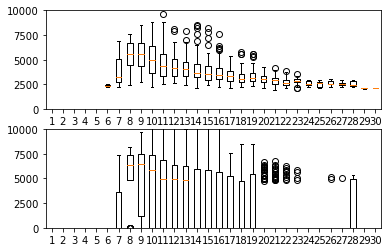

In [409]:
catch2 = spot_data_depth_correct_stdcandle(spot_data_depth, paramgrids_real)

In [411]:
a = fm.add_volume_mean(spot_data_depth, mv.stack, spotchannel, ij_rad=2, z_rad=1.1)

10 20 30 40 50 60 70 80 90 100 110 120 130 

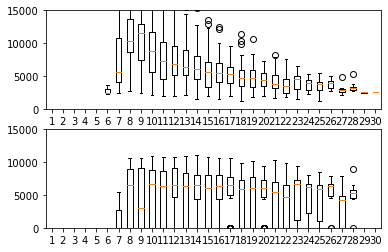

In [479]:
catch2 = spot_data_depth_correct_stdcandle(a, paramgrids_real, col_to_correct=13)

In [488]:
np.random.choice([1,2,3], 3)

array([1, 2, 1])